In [3]:
import sys
sys.path.append('../..')

In [4]:
import cv2

import os
import psutil

import random
import math
import copy
from functools import partial
from collections import Counter

import torch 
from torch import optim
from torch.optim import lr_scheduler
from torch import nn
from torch.nn import functional as F

import multiprocessing.dummy as mp

from pytorch_lightning import Trainer
from pytorch_lightning.core import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger


from lib.schedulers import DelayedScheduler
from lib.datasets import (max_lbl_nums, actual_lbl_nums, 
                          patches_rgb_mean_av1, patches_rgb_std_av1, 
                          get_train_test_img_ids_split)
from lib.dataloaders import PatchesDataset, WSIPatchesDatasetRaw, WSIPatchesDummyDataloader
from lib.augmentations import augment_v1_clr_only, augment_empty_clr_only
from lib.losses import SmoothLoss
from lib.trainers import WSIModuleV1

from lib.models.unetv1 import get_model
from lib.models.features_map import FeaturesMap, TiledFeaturesMap
from lib.models.wsi_resnets import Resnet_64x8x8

from sklearn.metrics import cohen_kappa_score

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [5]:
# import cv2
import numpy as np
# import pandas as pd
# from lib.datasets import patches_csv_path, patches_path
from lib.datasets import (patches_clean90_csv_path as patches_csv_path, patches_path,
                          patches_clean90_pkl_path as patches_pkl_path)
# from lib.dataloaders import imread, get_g_score_num, get_provider_num

In [6]:
train_img_ids, test_img_ids = get_train_test_img_ids_split()

test_img_ids[:4]

['e8baa3bb9dcfb9cef5ca599d62bb8046',
 '9b2948ff81b64677a1a152a1532c1a50',
 '5b003d43ec0ce5979062442486f84cf7',
 '375b2c9501320b35ceb638a3274812aa']

In [7]:
from lib.dataloaders import WSIPatchesDataloader, WSIPatchesDatasetRaw
from lib.utils import get_pretrained_model, get_features

In [8]:
batch_size = 16

In [9]:
#train_batch_path = '/mnt/HDDData/pdata/processed/pretrained_64x8x8/train/{}/'
#test_batch_path = '/mnt/HDDData/pdata/processed/pretrained_64x8x8/val/'

train_batch_path = '/mnt/SSDData/pdata/processed/pretrained_64x8x8/train/{}/'
test_batch_path = '/mnt/SSDData/pdata/processed/pretrained_64x8x8/val/'

train_loader = WSIPatchesDummyDataloader(train_batch_path, precalc_epochs=6, batch_size=batch_size, shuffle=True)
val_loader = WSIPatchesDummyDataloader(test_batch_path, precalc_epochs=6, batch_size=batch_size, shuffle=False)

In [10]:
batch = next(iter(train_loader))

In [11]:
features, ys, xs, provider, isup_grade, gleason_score = batch

In [21]:
features.shape

torch.Size([16, 300, 64, 8, 8])

In [19]:
features2 = F.avg_pool2d(features.view(-1, 64, 8, 8), 4).view(features.shape[:3] + (2, 2))

In [20]:
features2.shape

torch.Size([16, 300, 64, 2, 2])

In [64]:
from lib.models.features_map import RearrangedFeaturesMap
rf_map = RearrangedFeaturesMap(f_channels=64, f_size=8)

In [16]:
b = -1

In [65]:
t_imgs, t_d8imgs = rf_map(features, ys, xs)

In [13]:
t_d8imgs.shape

torch.Size([16, 64, 160, 160])

In [71]:
b += 1

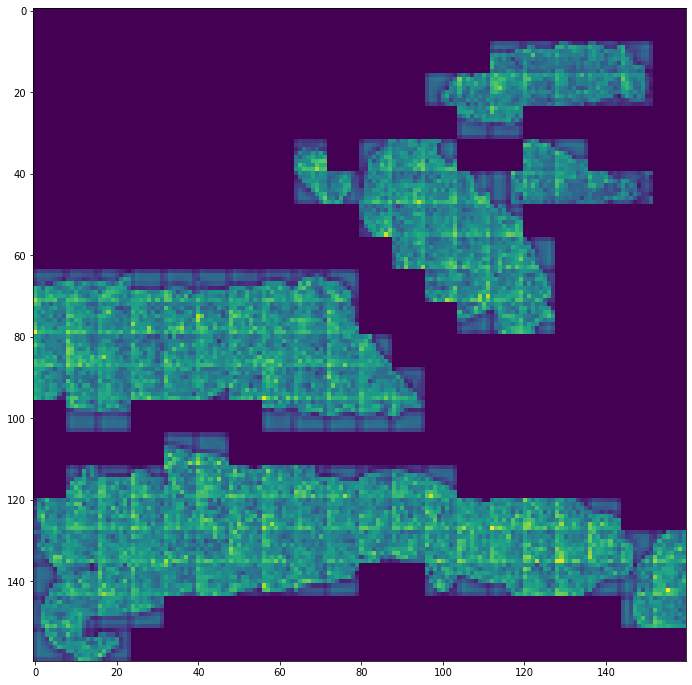

In [72]:
plt.figure(figsize=(12, 12))
plt.imshow(t_d8imgs[b, 0]);

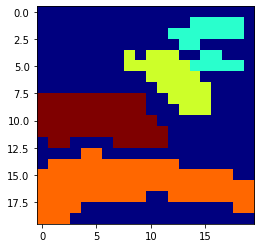

In [73]:
plt.imshow(t_imgs[b][..., 2], cmap='jet');

In [ ]:
18*18

In [11]:
def d8_transform(m, d8):
    if d8 & 0b001:
        m = m.transpose(1, 0, 2)
    if d8 & 0b010:
        m = m[:, ::-1]        
    if d8 & 0b100:
        m = m[::-1, :]  
        
    return m

def get_fg_score(img, p=2):        
    return (np.unique(img[..., 2], return_counts=True)[1][1:]**p).sum()

def get_bg_score(img, p=2):
    tmp = (img[..., 0] == -1).astype(np.uint8)
    dist_sum = (cv2.distanceTransform(tmp, cv2.DIST_L1, 5)**p).sum()
    return dist_sum

In [12]:
m = np.arange(4).reshape((2, 2, 1))

m2d8 = {}
d82m = {}
for i in range(8):
    m_ = d8_transform(m.copy(), i)
    m_ = ''.join([str(s) for s in m_.ravel().tolist()])
    m2d8[m_] = i
    d82m[i] = m_
    
d8pd8 = np.zeros((8, 8), dtype=np.uint8)
for i in range(8):
    for j in range(8):
        mi = d8_transform(m.copy(), i)
        mj = d8_transform(mi.copy(), j)
        mj = ''.join([str(s) for s in mj.ravel().tolist()])
        d8pd8[i, j] = m2d8[mj]

In [13]:
# d8pd8

In [14]:
# d8_rev = d8pd8.argmin(axis=-1)

In [15]:
d8_rev = [0, 1, 2, 5, 4, 3, 6, 7]

In [24]:
t_h, t_w = 20, 20
m_pad = t_h

In [25]:
b = -1

In [26]:
b += 1

r_mask = ys[b] > - 1

y_min, x_min = ys[b, r_mask].min(), xs[b, r_mask].min()
y_max, x_max = ys[b, r_mask].max(), xs[b, r_mask].max()

s_h = y_max - y_min + 1
s_w = x_max - x_min + 1

n_ys = (ys[b, r_mask]-y_min)
n_xs = (xs[b, r_mask]-x_min)

In [27]:
n0, n1 = 1, 200

In [28]:
%%time

o_t_img = np.full((t_h, t_w, 4), -1, dtype=np.int16)

o_s_img = np.zeros((s_h, s_w), dtype=np.uint8)
o_s_img[n_ys, n_xs] = 1

mask = np.ones((s_h+2*m_pad, s_w+2*m_pad), dtype=np.uint8)

def r(a, b):
    return random.random() * (b - a) + a 

o_best = None
o_best_score = -99999999
for _ in range(n0):
    p0, p1, p2 = 1.4, 1, 1
    a0, a1, a2 = 1, 0.1, 1000

    s_img, t_img = o_s_img.copy(), o_t_img.copy()
    
    n = 0
    while s_img.max() != 0:
        best_step = None
        best_score = -99999999  

        s_fg_ys, s_fg_xs = np.where(s_img != 0)
        
        for a in range(n1):
            c_s_img, c_t_img = s_img.copy(), t_img.copy()

            d8 = random.randint(0, 7)
            # d8 = random.choice([0, 3, 5, 6])  # only rotation
            c_t_img = d8_transform(c_t_img, d8)

            t_empty_mask = c_t_img[..., 0] == -1
            t_empty_ys, t_empty_xs = np.where(t_empty_mask)

            r = random.randint(0, len(t_empty_ys)-1)
            t_y, t_x = t_empty_ys[r], t_empty_xs[r]

            r = random.randint(0, len(s_fg_ys)-1)
            s_y, s_x = s_fg_ys[r], s_fg_xs[r]

            mask.fill(1)

            m_y = s_y+m_pad-t_y
            m_x = s_x+m_pad-t_x

            mask[m_y:m_y+t_h, m_x:m_x+t_w] = ~t_empty_mask

            fimg = cv2.floodFill(c_s_img, mask[m_pad-1:-m_pad+1, m_pad-1:-m_pad+1], 
                                 (s_x, s_y), 2, flags=8)

            if fimg[0] > 0:
                blob_yxs = np.where(fimg[1] == 2)
                c_t_img[blob_yxs[0]-s_y+t_y, blob_yxs[1]-s_x+t_x] =\
                        np.stack(blob_yxs + (np.full_like(blob_yxs[0], n+1), 
                                             np.full_like(blob_yxs[0], d8)), axis=-1)

                c_s_img[c_s_img == 2] = 0
            else:
                print("WTF?")

            c_t_img = d8_transform(c_t_img, d8_rev[d8])

            score = (a0 * get_fg_score(c_t_img, p0) + 
                     a1 * get_bg_score(c_t_img, p1)**0.5 +
                     a2 * -(cv2.connectedComponents(c_s_img, connectivity=4)[0])**p2)
            # print(get_fg_score(c_t_img, 1), get_bg_score(c_t_img, 1)**0.5)

            if score > best_score:
                best_state = c_s_img, c_t_img
                best_score = score

        s_img, t_img = best_state
        n += 1
        
        # break
        
    if best_score > o_best_score:
        s_img, t_img = best_state    

CPU times: user 50.1 ms, sys: 307 µs, total: 50.4 ms
Wall time: 49.7 ms


In [29]:
s_img, t_img = best_state

In [31]:
get_fg_score(t_img, 1.4)

620.2268095202504

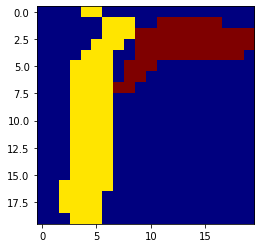

In [32]:
plt.imshow(t_img[..., 2], cmap='jet');

In [33]:
r_s_img = np.full_like(s_img, -1, dtype=np.int16)
for i in range(1, t_img[..., 2].max()+1):
    s_yxs = t_img[t_img[..., 2] == i, :2]
    r_s_img[s_yxs[:, 0], s_yxs[:, 1]] = i

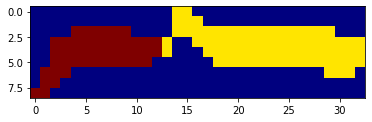

In [34]:
plt.imshow(r_s_img, cmap='jet');

In [35]:
def torch_d8_transform(m, d8):
    if d8 & 0b001:
        m = m.transpose(-2, -1)
    if d8 & 0b010:
        m = torch.flip(m, [-1])        
    if d8 & 0b100:
        m = torch.flip(m, [-2])  
        
    return m

In [36]:
f_size = 8
f_channels = 64
t_d8img = torch.zeros((f_channels, t_h*f_size, t_w*f_size), dtype=features.dtype, 
                      device=features.device)
d8 = 0
for i in range(1, t_img[..., 2].max()+1):
    t_i = t_img[..., 2] == i
    t_ys, t_xs = np.where(t_i)
    s_yxs = t_img[t_i, :2]
    d8_ = t_img[t_i, -1][0]
    d8 = d8_
    # d8 = d8pd8[d8, d8_]
    d8_r = d8_rev[d8]
    
    for n in range(len(s_yxs)):
        f_idx = ((ys[b]-y_min) == s_yxs[n, 0]) & ((xs[b]-x_min) == s_yxs[n, 1])
        f = features[b, f_idx][0]
        f = torch_d8_transform(f, d8_r)
        t_d8img[:, t_ys[n]*f_size:(t_ys[n]+1)*f_size, 
                t_xs[n]*f_size:(t_xs[n]+1)*f_size] = f
    
    print(d8_, d8, d8_r)
    
    # break
    #if i == 2:
    #    break

5 5 3
0 0 0


In [37]:
t_d8img.shape

torch.Size([64, 160, 160])

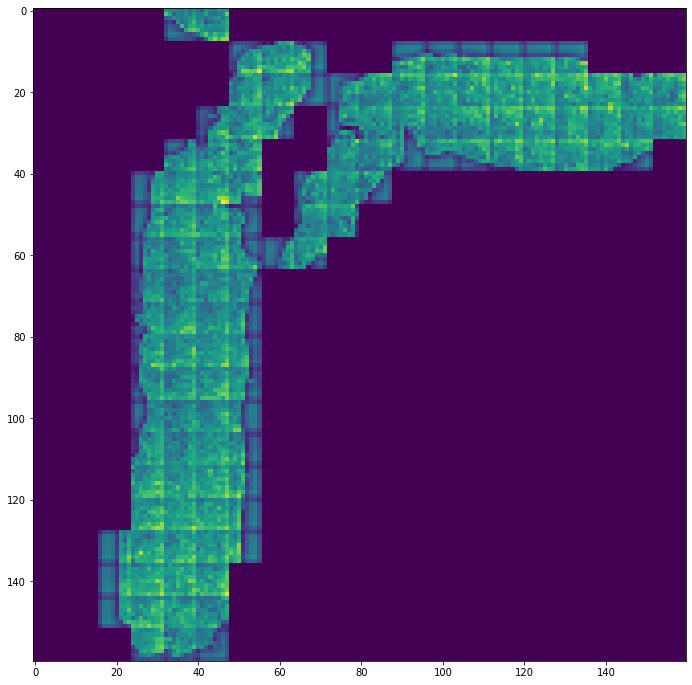

In [38]:
plt.figure(figsize=(12, 12))
plt.imshow(t_d8img[0]);